# ResNet Implementation with PyTorch


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Download CIFAR10 & Define DataLoader

- `ToTensor()` transforms data into `Tensor` type and also normalizes into `[0,1]` range.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = CIFAR10(root='', train=True, download=True, transform=transform)
testset = CIFAR10(root='', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataset.data.shape

(50000, 32, 32, 3)

In [5]:
testset.data.shape

(10000, 32, 32, 3)

In [6]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_num = int(len(dataset)*0.9)
valid_num = len(dataset) - train_num

trainset, validset = random_split(dataset, [train_num, valid_num])

In [8]:
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

## Construct Model

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=(3,3), stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            nn.Conv2d(out_planes, out_planes, kernel_size=(3,3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_planes)
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_planes != out_planes:
            self.shortcut.add_module('conv', nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True))                                     
        
    def forward(self, x):
        x = self.residual(x) + self.shortcut(x)
        x = self.relu(x)
        return x
    

In [10]:
'''
숙제!
'''

class BottleNeck(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_planes, out_planes//4, kernel_size=(1,1), stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_planes//4),
            nn.ReLU(),
            nn.Conv2d(out_planes//4, out_planes//4, kernel_size=(3,3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_planes//4),
            nn.ReLU(),
            nn.Conv2d(out_planes//4, out_planes, kernel_size=(1,1), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_planes)
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_planes != out_planes:
            self.shortcut.add_module('conv', nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True))
            
    def forward(self, x):
        x = self.residual(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, channels, init_weights=True):
        super(ResNet,self).__init__()
        
        self.conv = nn.Conv2d(3, channels[0], kernel_size=7, stride=1, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(channels[0])
        self.relu = nn.ReLU()
        
        self.block1 = BasicBlock(channels[0], channels[0], stride=1)
        self.block2 = BasicBlock(channels[0], channels[1], stride=2)
        self.block3 = BasicBlock(channels[1], channels[2], stride=1)
        self.block4 = BasicBlock(channels[2], channels[3], stride=2)
        self.block5 = BasicBlock(channels[3], channels[4], stride=2)
        self.block6 = BasicBlock(channels[4], channels[4], stride=1)
        
        self.avgpool = nn.AvgPool2d(kernel_size=(4,4))
        
        self.fc1 = nn.Linear(channels[4], channels[4]//4, bias=False)
        self.bn1 = nn.BatchNorm1d(channels[4]//4)
        self.fc2 = nn.Linear(channels[4]//4, 10, bias=True)
        
        if init_weights:
            self.initialize_weights()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.block1(x)      
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)        
        
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

In [12]:
model = ResNet(channels=[16,16,32,64,128]).to(device)

In [13]:
summary(model,input_size=(3,32,32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           2,352
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

In [14]:
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [15]:
from tqdm import tqdm 

def train(net, trainloader, validloader, epochs, device, loss_ftn, optimizer, scheduler=None, temperature=None):
    losses = []
    accs = []
    valid_losses = []
    valid_accs = []
    
    for epoch in range(epochs):
        running_loss = 0
        valid_loss = 0
        correct = 0
        total = 0
        valid_correct = 0
        valid_total = 0
        num_iter = 0

        for i, data in tqdm(enumerate(trainloader, 0)):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = loss_ftn(outputs, labels)
            loss.backward()
            optimizer.step()

            num_iter += 1
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = (correct/total)*100
        losses.append(running_loss/num_iter)
        accs.append(accuracy)
        
        valid_num_iter = 0
        with torch.no_grad():
            for data in validloader:
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = net(images)
                loss = loss_ftn(outputs, labels)
                
                valid_num_iter += 1
                valid_loss += loss.item()

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = (valid_correct/valid_total)*100
        valid_losses.append(valid_loss/valid_num_iter)
        valid_accs.append(valid_accuracy)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Training Accuracy: %.2f, Validation Loss: %.3f, Validation Accuracy: %.2f \n' 
              %(epoch+1, running_loss/num_iter, accuracy, valid_loss/valid_num_iter, valid_accuracy))
            
        if scheduler is not None:
            scheduler.step()
                        
    return losses, accs, valid_losses, valid_accs

In [16]:
def test(net, testloader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on 10000 test images: {100 * correct / total} %')

In [17]:
EPOCHS=30

losses, accs, valid_losses, valid_accs = train(model, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:05, 67.72it/s]


EPOCH 1 Completed. 
 Training Loss: 1.696, Training Accuracy: 36.85, Validation Loss: 1.429, Validation Accuracy: 47.62 

Adjusting learning rate of group 0 to 9.5000e-03.


352it [00:05, 65.92it/s]


EPOCH 2 Completed. 
 Training Loss: 1.321, Training Accuracy: 51.78, Validation Loss: 1.194, Validation Accuracy: 56.66 

Adjusting learning rate of group 0 to 9.0250e-03.


352it [00:05, 64.87it/s]


EPOCH 3 Completed. 
 Training Loss: 1.076, Training Accuracy: 61.51, Validation Loss: 1.021, Validation Accuracy: 63.54 

Adjusting learning rate of group 0 to 8.5737e-03.


352it [00:05, 64.87it/s]


EPOCH 4 Completed. 
 Training Loss: 0.888, Training Accuracy: 68.63, Validation Loss: 0.905, Validation Accuracy: 67.90 

Adjusting learning rate of group 0 to 8.1451e-03.


352it [00:06, 53.32it/s]


EPOCH 5 Completed. 
 Training Loss: 0.763, Training Accuracy: 73.03, Validation Loss: 0.825, Validation Accuracy: 71.34 

Adjusting learning rate of group 0 to 7.7378e-03.


352it [00:05, 65.26it/s]


EPOCH 6 Completed. 
 Training Loss: 0.652, Training Accuracy: 77.20, Validation Loss: 0.797, Validation Accuracy: 72.76 

Adjusting learning rate of group 0 to 7.3509e-03.


352it [00:05, 63.81it/s]


EPOCH 7 Completed. 
 Training Loss: 0.559, Training Accuracy: 80.36, Validation Loss: 0.797, Validation Accuracy: 73.60 

Adjusting learning rate of group 0 to 6.9834e-03.


352it [00:05, 66.73it/s]


EPOCH 8 Completed. 
 Training Loss: 0.473, Training Accuracy: 83.52, Validation Loss: 0.749, Validation Accuracy: 75.20 

Adjusting learning rate of group 0 to 6.6342e-03.


352it [00:05, 63.96it/s]


EPOCH 9 Completed. 
 Training Loss: 0.394, Training Accuracy: 86.19, Validation Loss: 0.788, Validation Accuracy: 74.96 

Adjusting learning rate of group 0 to 6.3025e-03.


352it [00:05, 60.57it/s]


EPOCH 10 Completed. 
 Training Loss: 0.314, Training Accuracy: 88.92, Validation Loss: 0.862, Validation Accuracy: 74.60 

Adjusting learning rate of group 0 to 5.9874e-03.


352it [00:06, 56.08it/s]


EPOCH 11 Completed. 
 Training Loss: 0.250, Training Accuracy: 91.24, Validation Loss: 0.933, Validation Accuracy: 75.18 

Adjusting learning rate of group 0 to 5.6880e-03.


352it [00:06, 55.89it/s]


EPOCH 12 Completed. 
 Training Loss: 0.196, Training Accuracy: 93.06, Validation Loss: 0.976, Validation Accuracy: 74.38 

Adjusting learning rate of group 0 to 5.4036e-03.


352it [00:06, 56.31it/s]


EPOCH 13 Completed. 
 Training Loss: 0.144, Training Accuracy: 94.92, Validation Loss: 1.062, Validation Accuracy: 74.30 

Adjusting learning rate of group 0 to 5.1334e-03.


352it [00:06, 56.53it/s]


EPOCH 14 Completed. 
 Training Loss: 0.107, Training Accuracy: 96.20, Validation Loss: 1.091, Validation Accuracy: 75.48 

Adjusting learning rate of group 0 to 4.8767e-03.


352it [00:06, 56.27it/s]


EPOCH 15 Completed. 
 Training Loss: 0.093, Training Accuracy: 96.67, Validation Loss: 1.214, Validation Accuracy: 75.22 

Adjusting learning rate of group 0 to 4.6329e-03.


352it [00:06, 55.93it/s]


EPOCH 16 Completed. 
 Training Loss: 0.071, Training Accuracy: 97.58, Validation Loss: 1.241, Validation Accuracy: 75.36 

Adjusting learning rate of group 0 to 4.4013e-03.


352it [00:05, 60.92it/s]


EPOCH 17 Completed. 
 Training Loss: 0.061, Training Accuracy: 97.91, Validation Loss: 1.307, Validation Accuracy: 75.68 

Adjusting learning rate of group 0 to 4.1812e-03.


352it [00:05, 65.80it/s]


EPOCH 18 Completed. 
 Training Loss: 0.052, Training Accuracy: 98.18, Validation Loss: 1.358, Validation Accuracy: 74.80 

Adjusting learning rate of group 0 to 3.9721e-03.


352it [00:05, 67.07it/s]


EPOCH 19 Completed. 
 Training Loss: 0.048, Training Accuracy: 98.28, Validation Loss: 1.402, Validation Accuracy: 75.30 

Adjusting learning rate of group 0 to 3.7735e-03.


352it [00:06, 58.02it/s]


EPOCH 20 Completed. 
 Training Loss: 0.041, Training Accuracy: 98.62, Validation Loss: 1.482, Validation Accuracy: 74.76 

Adjusting learning rate of group 0 to 3.5849e-03.


352it [00:05, 66.04it/s]


EPOCH 21 Completed. 
 Training Loss: 0.032, Training Accuracy: 98.96, Validation Loss: 1.465, Validation Accuracy: 75.04 

Adjusting learning rate of group 0 to 3.4056e-03.


352it [00:05, 66.46it/s]


EPOCH 22 Completed. 
 Training Loss: 0.027, Training Accuracy: 99.13, Validation Loss: 1.559, Validation Accuracy: 75.30 

Adjusting learning rate of group 0 to 3.2353e-03.


352it [00:05, 67.12it/s]


EPOCH 23 Completed. 
 Training Loss: 0.025, Training Accuracy: 99.19, Validation Loss: 1.555, Validation Accuracy: 74.46 

Adjusting learning rate of group 0 to 3.0736e-03.


352it [00:05, 63.89it/s]


EPOCH 24 Completed. 
 Training Loss: 0.026, Training Accuracy: 99.11, Validation Loss: 1.580, Validation Accuracy: 74.94 

Adjusting learning rate of group 0 to 2.9199e-03.


352it [00:05, 61.56it/s]


EPOCH 25 Completed. 
 Training Loss: 0.017, Training Accuracy: 99.43, Validation Loss: 1.616, Validation Accuracy: 75.24 

Adjusting learning rate of group 0 to 2.7739e-03.


352it [00:05, 63.63it/s]


EPOCH 26 Completed. 
 Training Loss: 0.017, Training Accuracy: 99.42, Validation Loss: 1.654, Validation Accuracy: 75.76 

Adjusting learning rate of group 0 to 2.6352e-03.


352it [00:05, 67.01it/s]


EPOCH 27 Completed. 
 Training Loss: 0.012, Training Accuracy: 99.56, Validation Loss: 1.659, Validation Accuracy: 75.86 

Adjusting learning rate of group 0 to 2.5034e-03.


352it [00:05, 65.49it/s]


EPOCH 28 Completed. 
 Training Loss: 0.015, Training Accuracy: 99.49, Validation Loss: 1.734, Validation Accuracy: 75.82 

Adjusting learning rate of group 0 to 2.3783e-03.


352it [00:05, 65.34it/s]


EPOCH 29 Completed. 
 Training Loss: 0.016, Training Accuracy: 99.47, Validation Loss: 1.769, Validation Accuracy: 75.24 

Adjusting learning rate of group 0 to 2.2594e-03.


352it [00:06, 57.37it/s]


EPOCH 30 Completed. 
 Training Loss: 0.012, Training Accuracy: 99.60, Validation Loss: 1.729, Validation Accuracy: 75.34 

Adjusting learning rate of group 0 to 2.1464e-03.


In [18]:
test(model, testloader, device)

100%|██████████| 79/79 [00:00<00:00, 120.42it/s]

Accuracy of the network on 10000 test images: 75.11 %


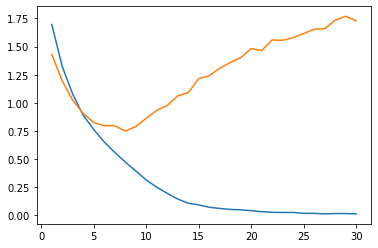

In [20]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses)
plt.plot(np.arange(1, EPOCHS+1), valid_losses)
plt.show()

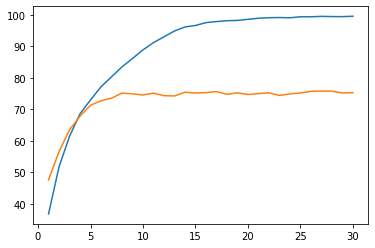

In [21]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs)
plt.plot(np.arange(1, EPOCHS+1), valid_accs)
plt.show()